# Tutorial 2: Solving a cantilever beam with Finite Differences

In this tutorial we will learn how to obtain the motion of a cantilever beam using Finite Differences

The equation of motion of the beam is:
$$\rho A \ddot{w} + EI w'''' = q(x,t)$$

where $w(t)$ is the deflection of the beam, $\rho$ its density, $A$ its cross-sectional area, $E$ its Young's modulus, $I$ its second moment of area and $q(x,t)$ a distributed force applied to the beam. 

The boundary conditions for a cantilever beam are:
$$ w(0) = w'(0) = \dot{w}(0) = \ddot{w}(0) = 0 $$
$$EI\ w^{'''}(L) = F_{\mathrm{ext}}(t) $$
$$EI\ w^{''}(L) = M_{\mathrm{ext}}(t) $$

## The roadmap to finde the beam deflection  using Finite Differences

The steps needed to discretize the beam are listed next. 
1. Discretize space into $N + 1$ points.
2. Discretize the EOM of the beam. To do this, you will have to approximate the 4th order derivative with FD. Use a second order approximation. You can find the coefficients [here](https://en.wikipedia.org/wiki/Finite_difference_coefficient) (or google `finite difference coefficients' and click the Wikipedia page)}.
3. Apply the boundary conditions. Use the definition of discrete derivatives and EOM to find the relation between the ghost points and the interior points.
4. Combine all equations into matrices. 
5. Solve the resulting ODE system

In [1]:
pip install ipympl;

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scipy;

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Load packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp

### Step 1: Discretize space

In [8]:
L = 10 # length [m]
N = 20 # Number of elements
x = np.linspace(0,L,N+1)

# Structural parameters (not realistic)
E = 1
I = 1
rho = 1
A = 1

# Force
q = 1
def Fext(t):
    return 1.0
def Mext(t):
    return 0.0

### Step 2: Discretize the EOM of the beam

Using the coefficients for a centered FD scheme for 4th order derivatives with 2nd order accuracy we have:

$$ w_i^{''''} = \frac{w_{i-2}-4w_{i-1}+6w_i-4w_{i+1}+w_{i+2}}{\Delta x^4}$$

The equivalent scheme for the 3rd order derivative is:

$$ w_i^{'''} = \frac{-0.5w_{i-2}+w_{i-1}-w_{i+1}+0.5w_{i+2}}{\Delta x^3}$$

For the 2nd order derivative:

$$ w_i^{''} = \frac{w_{i-1}-2w_i+w_{i+1}}{\Delta x^2}$$

And for the 1st order derivative:

$$ w_i^{'} = \frac{-0.5w_{i-1}+0.5w_{i+1}}{\Delta x}$$

Replacing these expressions into the equation of motion we get the following discrete system:

$$ \rho A \ddot{w}_i + EI \frac{w_{i-2}-4w_{i-1}+6w_i-4w_{i+1}+w_{i+2}}{\Delta x^4} = q_i $$

### Step 3: Apply boundary conditions

At $x=0$ we have that $w(0)=0$, then 
$$ w_0 = 0 $$

At $x=0$ we also have that $w^{'}(0)=0$, then using the approximation of $w^{'}_i$ we get 
$$ w_{-1} = w_1 $$

Since we know the values of $w(0)$ for all times, we will not include them on the system. Using all these relations, we get the discrete equation for $i=1$ and $i=2$ as:
$$ \rho A \ddot{w}_1 + EI \frac{7w_1-4w_{2}+w_{3}}{\Delta x^4} = q_1 $$
$$ \rho A \ddot{w}_2 + EI \frac{-4w_{1}+6w_2-4w_{3}+w_{4}}{\Delta x^4} = q_2 $$

On the other side, we use the force and moments relation
$$EI\ w^{''}(L) = M_{\mathrm{ext}}(t) $$
$$EI\frac{w_{N-1}-2w_{N}+w_{N+1}}{\Delta x^2} = M_{\mathrm{ext}}(t)$$
Thus
$$w_{N+1} = \frac{\Delta x^2}{EI}M_{\mathrm{ext}}(t)-w_{N-1}+2w_{N}$$

And
$$EI\ w^{'''}(L) = F_{\mathrm{ext}}(t) $$
$$EI \frac{-0.5w_{N-2}+w_{N-1}-w_{N+1}+0.5w_{N+2}}{\Delta x^3} = F_{\mathrm{ext}}(t) $$
$$w_{N+2} = \frac{2\Delta x^3}{EI}F_{\mathrm{ext}}(t) + \frac{2\Delta x^2}{EI}M_{\mathrm{ext}}(t)+ w_{N-2} - 4w_{N-1} + 4w_N  $$

So, the discrete equations of motion for $i=N$ and $i=N-1$ are:
$$ \rho A \ddot{w}_N + EI \frac{2w_{N-2} - 4w_{N-1} + 2w_N}{\Delta x^4} = q_N - \frac{2}{\Delta x}F_{\mathrm{ext}}(t) + \frac{2}{\Delta x^2}M_{\mathrm{ext}}(t) $$

$$ \rho A \ddot{w}_{N-1} + EI \frac{w_{N-3}-4w_{N-2}+5w_{N-1}-2w_{N}}{\Delta x^4} = q_{N-1} - \frac{1}{\Delta x^2}M_{\mathrm{ext}}(t)$$



### Step 4: Matrix form

Summarizing we have the following discrete (in space) equations:

- For $i=1$:
$$ \rho A \ddot{w}_1 + EI \frac{7w_1-4w_{2}+w_{3}}{\Delta x^4} = q_1 $$
- For $i=2$:
$$ \rho A \ddot{w}_2 + EI \frac{-4w_{1}+6w_2-4w_{3}+w_{4}}{\Delta x^4} = q_2 $$
- For $i=3,...,N-2$:
$$ \rho A \ddot{w}_i + EI \frac{w_{i-2}-4w_{i-1}+6w_i-4w_{i+1}+w_{i+2}}{\Delta x^4} = q_i $$
- For $i=N-1$:
$$ \rho A \ddot{w}_{N-1} + EI \frac{w_{N-3}-4w_{N-2}+5w_{N-1}-2w_{N}}{\Delta x^4} = q_{N-1} - \frac{1}{\Delta x^2}M_{\mathrm{ext}}(t)$$
- For $i=N$:
$$ \rho A \ddot{w}_N + EI \frac{2w_{N-2} - 4w_{N-1} + 2w_N}{\Delta x^4} = q_N - \frac{2}{\Delta x}F_{\mathrm{ext}}(t) + \frac{2}{\Delta x^2}M_{\mathrm{ext}}(t) $$  

This is equivalent to the following system:
$$\rho A \left[\begin{matrix}
1&0&0&\ldots&0&0&0\\
0&1&0&\ldots&0&0&0\\
0&0&1&\ldots&0&0&0\\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots&\vdots\\
0&0&0&\ldots&1&0&0\\
0&0&0&\ldots&0&1&0\\
0&0&0&\ldots&0&0&1\\
\end{matrix}\right]\left[\begin{matrix}
\ddot{w}_1\\
\ddot{w}_2\\
\ddot{w}_3\\
\vdots\\
\ddot{w}_{N-2}\\
\ddot{w}_{N-1}\\
\ddot{w}_N\\
\end{matrix}\right]
+ \frac{EI}{\Delta x^4} \left[\begin{matrix}
7&-4&1&0&0&&0&0&0\\
-4&6&-4&1&0&\ldots&0&0&0\\
1&-4&6&-4&1&&0&0&0\\
&&\vdots&&&\ddots&&\vdots&\\
0&0&0&&1&-4&6&-4&1\\
0&0&0&\ldots&0&1&-4&5&-2\\
0&0&0& &0&0&2&-4&2\\
\end{matrix}\right]\left[\begin{matrix}
w_1\\
w_2\\
w_3\\
\vdots\\
w_{N-2}\\
w_{N-1}\\
w_N\\
\end{matrix}\right] = \left[\begin{matrix}
q_1\\
q_2\\
q_3\\
\vdots\\
q_{N-2}\\
q_{N-1} - \frac{1}{\Delta x^2}M_{\mathrm{ext}}(t)\\
q_N - \frac{2}{\Delta x}F_{\mathrm{ext}}(t) + \frac{2}{\Delta x^2}M_{\mathrm{ext}}(t) \\
\end{matrix}\right]$$

And in a compact form:
$$\boldsymbol{M}\ddot{\boldsymbol{w}}+\boldsymbol{K}\boldsymbol{w}=\boldsymbol{F}$$

In [6]:
# Construct the matrices
M = np.eye(N)
K = np.zeros((N,N))

# Fill in stiffness matrix
K[0,0] = 7;  K[0,1] = -4; K[0,2] = 1
K[1,0] = -4;  K[1,1] = 6; K[1,2] = -4; K[1,3] = 1
K[N-2,N-4] = 1;  K[N-2,N-3] = -4; K[N-2,N-2] = 5; K[N-2,N-1] = -2
K[N-1,N-3] = 2; K[N-1,N-2] = -4; K[N-1,N-1] = 2
for i in range(2,N-2):
    K[i,range(i-2,i+3)] = [1, -4, 6, -4, 1]
    
# Apply scaling
dx = L/N
M = rho*A*M
K = E*I/(dx**4)*K

# Fill in force
def F(t):
    Ft = np.zeros((N,))
    for i in range(0,N):
        Ft[i]=q
    Ft[N-2] = Ft[N-2] - Mext(t)/(dx**2)
    Ft[N-1] = Ft[N-1] - 2*Fext(t)/(dx) + 2*Mext(t)/(dx**2)
    return Ft

# Step 5: Solve the ODE system

Now, we just need to apply what we learned in the previous session to solve the dynamic problem. The main novelty is that here we work with matrices.

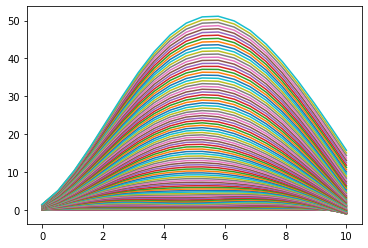

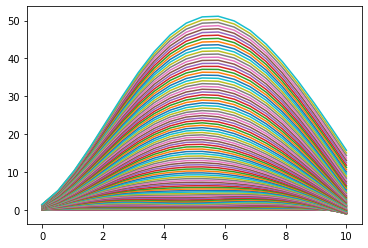

In [12]:
# Define the ODE function (given q, return dq)
def q_dot(t,q):
    displ = q[0:N]
    velos = q[N:2*N]
    accel = np.linalg.inv(M).dot((F(t)-K.dot(displ)))
    dq = np.zeros((2*N,))
    dq[0:N] = velos
    dq[N:2*N] = accel
    return dq

# Define initial state
q0 = np.zeros(2*N)

# Define time interval and time evaluation points
tspan = np.linspace(0,10,100)

# Solve
sol = solve_ivp(fun=q_dot,t_span=[0,10],y0=q0,t_eval=tspan)

# Plot
import time
import pylab as pl
from IPython import display
for i in range(0,len(tspan)):
    pl.plot(np.linspace(0,L,N),sol.y[0:N,i])
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.05)
